<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/CooksDStudent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.special import logit

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style
warnings.filterwarnings('ignore') #Disable warning

In [3]:
# Import dependence variable
odr = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/monthlyODR.csv'
)

# Select segment, drop columns
odr = odr.query(
    "Segment == 'CU'"
).drop(
    ['Segment', 'Monthkey'],
    axis = 1
).eval(
    "ODR = Bad / N"
)

# Transform to logit
y = logit(odr['ODR'])
y[:5]

0   -3.236680
1   -3.162347
2   -3.127475
3   -3.093313
4   -3.061565
Name: ODR, dtype: float64

In [4]:
# Import macroeconomics data
mev = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroTransformed.csv'
)

# Select variables for linear regression model
selectedVars = ['GDP_C_lg12', 'MPI_C_lg12']
X = sm.add_constant(mev[selectedVars]) #Add intercept
X.head(5)

,const,GDP_C_lg12,MPI_C_lg12
0,1.0,0.125214,0.239164
1,1.0,0.086355,0.119307
2,1.0,0.052505,0.143477
3,1.0,0.032748,0.089870
4,1.0,0.026525,0.046398


In [5]:
# Linear regression model
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    ODR   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     61.68
Date:                Thu, 24 Feb 2022   Prob (F-statistic):           6.99e-15
Time:                        12:14:41   Log-Likelihood:                 100.82
No. Observations:                  59   AIC:                            -195.6
Df Residuals:                      56   BIC:                            -189.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9473      0.019   -155.761      0.0

### Studentised Residual
The Studentised Residual is a measure of the change in the predicted values upon deletion of that observation from the data set; hence, it measures the influence of the observation on the estimated regression coefficients.

It is a method in identifying outliers. Having a few large absolute Studentised Residual is no cause for alarm. Many observations having absolute studentized residuals greater than two are deemed outliers and might indicate an inadequate model. Absolute studentized residuals greater than three are rarer; they should be regarded as extreme, and the data should be reviewed carefully.

The statistic threshold for the test is shown below:

Thresholds | Description 
-----------|------------
abs(Studentised Residual) > 2 | Outliers are presented 
abs(Studentised Residual) <= 2 | Outliers are not presented 


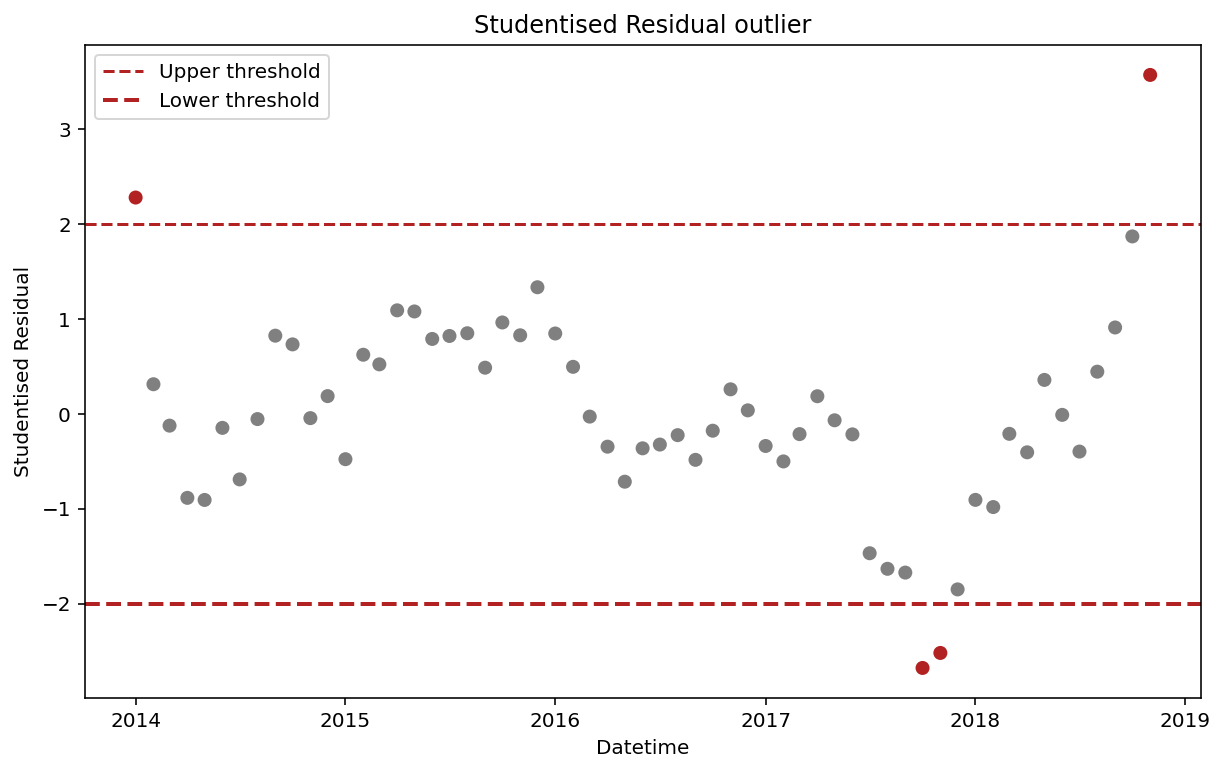

In [6]:
# Studentised Residual
StudentRes = result.outlier_test()['student_resid']

# Studentised Residual threshold
StudentResThres = 2

# Control plot
colors = np.where(
    abs(StudentRes) > StudentResThres,
    'firebrick',
    'gray'
)
dates = pd.to_datetime(mev['Date'])

# Plot
plt.figure(figsize = (10, 6))
plt.scatter(
    dates,
    StudentRes,
    color = colors
)
plt.axhline(
    StudentResThres,
    c = 'firebrick',
    linestyle = '--',
    linewidth = 1.5,
    label = 'Upper threshold'
)
plt.axhline(
    -StudentResThres,
    c = 'firebrick',
    linestyle = '--',
    linewidth = 2,
    label = 'Lower threshold'
)
plt.title("Studentised Residual outlier")
plt.xlabel('Datetime')
plt.ylabel("Studentised Residual")
plt.legend(frameon = True, facecolor = 'White')
plt.show()

### Cook’s Distance
The Cook’s Distance is a measure of overall influence a data point has in a statistical regression analysis. The measurement includes a combination of the observation’s leverage as well as residual values. Higher leverage and residual values would result in a higher Cook’s Distance, indicating that the data point strongly influences the fitted values.

The statistic threshold for the test is shown below:

Thresholds | Description 
-----------|------------
Cook's D > 4/n | Outliers are presented 
Cook's D <= 4/n | Outliers are not presented


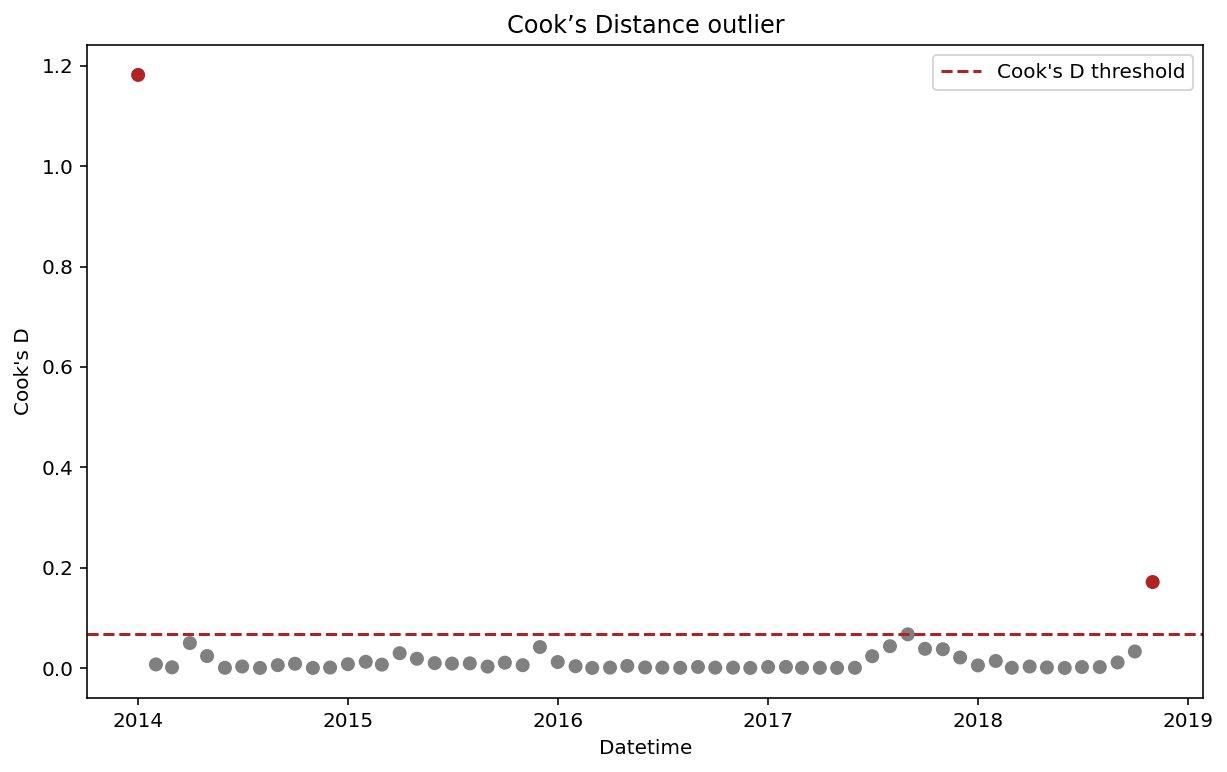

In [7]:
# Cook’s Distance
influence = result.get_influence()
CooksD, _ = influence.cooks_distance

# Cook’s Distance threshold
CooksDThres = 4 / CooksD.shape[0]

# Control color
colors = np.where(
    CooksD > CooksDThres,
    'firebrick',
    'gray'
)

# Plot
plt.figure(figsize = (10, 6))
plt.scatter(
    dates,
    CooksD,
    color = colors
)
plt.axhline(
    CooksDThres,
    c = 'firebrick',
    linestyle = '--',
    linewidth = 1.5,
    label = "Cook's D threshold"
)
plt.title("Cook’s Distance outlier")
plt.xlabel('Datetime')
plt.ylabel("Cook's D")
plt.legend(frameon = True, facecolor = 'White')
plt.show()